In [1]:
import hopsworks
import pandas as pd
import numpy as np
import os
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from hsml.model_schema import ModelSchema
from hsml.schema import Schema
import joblib

sns.set_palette('husl')
%matplotlib inline

In [2]:
project = hopsworks.login()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196773


In [3]:
fs = project.get_feature_store()
heart_fg = fs.get_feature_group(name="heart", version=1)

Connected. Call `.close()` to terminate connection gracefully.


# Get Data from Feature Store


In [ ]:
query = heart_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="heart",
                                  version=1,
                                  description="Read from Heart dataset",
                                  labels=["heart_disease"],
                                  query=query)
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_size=0.2)

# Remove timestamp
X_train = X_train.drop(columns=['timestamp'])
X_test = X_test.drop(columns=['timestamp'])

In [4]:
# Load it locally (faster)
# heart_df = pd.read_csv('dataset/heart_preprocessed.csv')

# y = heart_df['heart_disease']
# X = heart_df.drop(columns=['heart_disease', 'timestamp'])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Pipeline

In [5]:
preprocessing_pipeline = joblib.load('heart_model/preprocessing_pipeline.pkl')

In [6]:
X_train = preprocessing_pipeline.transform(X_train)
X_test = preprocessing_pipeline.transform(X_test)

# Handle Imbalance

2023-12-29 00:19:30,131 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-29 00:19:30,206 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='heart_disease', ylabel='count'>

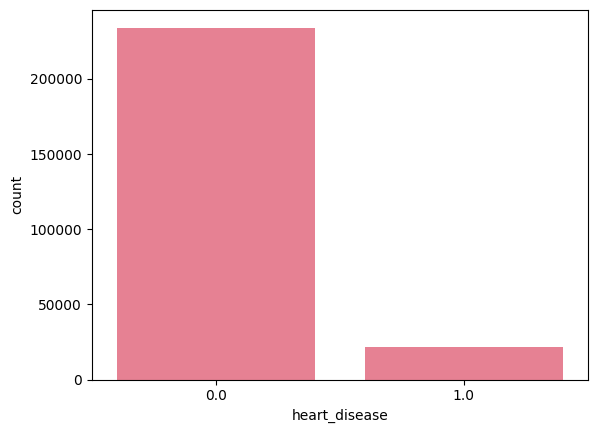

In [7]:
heart_df_train = pd.DataFrame(y_train, columns=['heart_disease'])
sns.countplot(x='heart_disease', data=heart_df_train)

In [8]:
ros = SMOTE(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

In [9]:
heart_df_train_res = pd.DataFrame(y_train_res, columns=['heart_disease'])

2023-12-29 00:19:31,340 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-29 00:19:31,466 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='heart_disease', ylabel='count'>

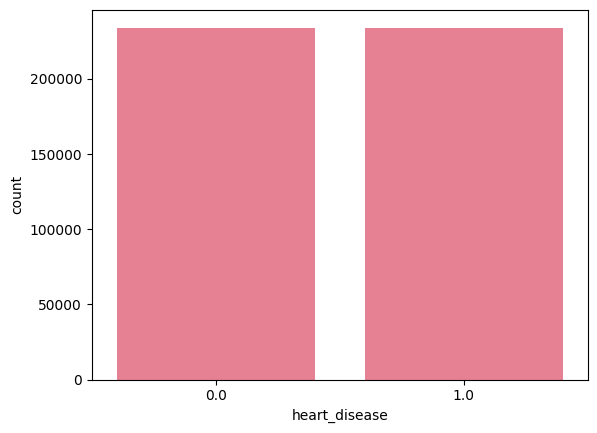

In [10]:
sns.countplot(x='heart_disease', data=heart_df_train_res)

# Train

In [11]:
base_model = DummyClassifier(strategy='most_frequent')
base_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [13]:
default_rf = RandomForestClassifier()
default_rf.fit(X_train_res, y_train_res)

In [13]:
# Save random search results to avoid re-running
if not os.path.exists('train/rcv_data.pkl'):
    model = RandomForestClassifier()
    param_grid = {'n_estimators': [100, 150, 200],
                'max_features': ['sqrt', 'log2'],
                'max_depth': [None, 2, 5, 10],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 5, 10],
                'bootstrap': [True, False]}
    rand_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='f1_weighted', n_iter=100, random_state=42, n_jobs=2, verbose=True)
    rand_search.fit(X_train, y_train)
    joblib.dump(rand_search, 'train/rcv_data.pkl')
else:
    rand_search = joblib.load('train/rcv_data.pkl')

print(f"Best params: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")
best_model = rand_search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


Best params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best score: 0.8866028544105445


In [14]:
if not os.path.exists('train/mlp_model.pkl'):
    mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000, verbose=True)
    mlp_model.fit(X_train, y_train)
    joblib.dump(mlp_model, 'train/mlp_model.pkl')
else:
    rand_search = joblib.load('train/mlp_model.pkl')

Iteration 1, loss = 0.23213175
Iteration 2, loss = 0.22540128
Iteration 3, loss = 0.22441446
Iteration 4, loss = 0.22381057
Iteration 5, loss = 0.22325605
Iteration 6, loss = 0.22284617
Iteration 7, loss = 0.22249957
Iteration 8, loss = 0.22201353
Iteration 9, loss = 0.22144486
Iteration 10, loss = 0.22114765
Iteration 11, loss = 0.22071564
Iteration 12, loss = 0.22005838
Iteration 13, loss = 0.21930195
Iteration 14, loss = 0.21895537
Iteration 15, loss = 0.21834864
Iteration 16, loss = 0.21782460
Iteration 17, loss = 0.21716250
Iteration 18, loss = 0.21657169
Iteration 19, loss = 0.21588841
Iteration 20, loss = 0.21508643
Iteration 21, loss = 0.21457660
Iteration 22, loss = 0.21378992
Iteration 23, loss = 0.21316666
Iteration 24, loss = 0.21237417
Iteration 25, loss = 0.21148247
Iteration 26, loss = 0.21072646
Iteration 27, loss = 0.21009496
Iteration 28, loss = 0.20947655
Iteration 29, loss = 0.20880521
Iteration 30, loss = 0.20800871
Iteration 31, loss = 0.20729824
Iteration 32, los

In [15]:
def test_model(model, X_test, y_test, name='Model'):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)

    print(f"---- Results for {name} ----")
    print(report)
    print(f"SCORE (f1_weighted): {f1_score(y_test, y_pred, average='weighted')}\n\n")

test_model(base_model, X_test, y_test, name='Dummy (Baseline)')
test_model(default_rf, X_test, y_test, name='Random Forest')
test_model(mlp_model, X_test, y_test, name='MLP')
test_model(best_model, X_test, y_test, name='Random Forest (Optimized)')

---- Results for Dummy (Baseline) ----
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     58367
         1.0       0.00      0.00      0.00      5592

    accuracy                           0.91     63959
   macro avg       0.46      0.50      0.48     63959
weighted avg       0.83      0.91      0.87     63959



SCORE (f1_weighted): 0.8708518910234326


---- Results for Random Forest ----
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93     58367
         1.0       0.27      0.27      0.27      5592

    accuracy                           0.87     63959
   macro avg       0.60      0.60      0.60     63959
weighted avg       0.87      0.87      0.87     63959

SCORE (f1_weighted): 0.8723956137114395


---- Results for MLP ----
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     58367
         1.0       0.32      0.17      0.22      5592

    accuracy                           0.90     63959
   macro avg       0.62      0.57      0.58     63959
weighted avg       0.87      0.90      0.88     63959

SCORE (f1_weighted): 0.8811272156442784


---- Results for Random Forest (Optimized) ----
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     58367
 

# Store in Modal

In [12]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="heart_model"
os.makedirs(model_dir, exist_ok=True)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(best_model, model_dir + "/heart_model.pkl")
# Already stored in the feature extraction
joblib.dump(preprocessing_pipeline, model_dir + "/preprocessing_pipeline.pkl")


# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
heart_model = mr.python.create_model(
    name="heart_model", 
    model_schema=model_schema,
    description="Heart Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
heart_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/807567705 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/10023 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/243 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/196773/models/heart_model/1


Model(name: 'heart_model', version: 1)